In [47]:
import serial
import time
import csv

# Replace with your Arduino's port (e.g. 'COM3', '/dev/ttyACM0', etc.)
ser = serial.Serial('/dev/cu.usbmodem11101', 9600, timeout=1)

# Allow time for Arduino reset
time.sleep(2)
time_list = []
values = []
# Open a CSV file for writing
with open("distance_data.csv", mode="w", newline="") as f:
    writer = csv.writer(f)
    # Write a header row
    writer.writerow(["Time (s)", "Distance (cm)"])

    print("Logging distance for 10 seconds...")
    start_time = time.time()
    log_duration = 10  # seconds

    while True:
        current_time = time.time() - start_time
        if current_time > log_duration:
            break
        
        if ser.in_waiting > 0:
            line = ser.readline().decode('utf-8').strip()
            
            # Expecting just a numeric value from Arduino
            # If you see "Distance: 1196.93 cm", parse out the number
            dist_value = float(line)
            time_list.append(current_time)
            time_list.append(current_time+0.01)
            values.append(2000-dist_value)
            values.append(0)
            # Write the data (time + distance) to CSV
            writer.writerow([round(current_time, 2), 2000-dist_value])
            print(f"Time: {round(current_time, 2)}s | Distance: {dist_value} cm")

print("Done logging. CSV file saved as distance_data.csv")
ser.close()
print(time_list)
print(values)


Logging distance for 10 seconds...
Time: 0.0s | Distance: 1197.09 cm
Time: 0.01s | Distance: 1197.22 cm
Time: 1.03s | Distance: 195.42 cm
Time: 2.1s | Distance: 1196.83 cm
Time: 3.17s | Distance: 1196.88 cm
Time: 4.24s | Distance: 1197.0 cm
Time: 5.32s | Distance: 1197.07 cm
Time: 6.39s | Distance: 1196.88 cm
Time: 7.41s | Distance: 301.77 cm
Time: 8.48s | Distance: 1197.21 cm
Time: 9.55s | Distance: 1197.02 cm
Done logging. CSV file saved as distance_data.csv
[1.1920928955078125e-06, 0.010001192092895508, 0.013025045394897461, 0.023025045394897463, 1.0265779495239258, 1.0365779495239258, 2.0989019870758057, 2.1089019870758055, 3.171220064163208, 3.181220064163208, 4.243549108505249, 4.253549108505249, 5.315857887268066, 5.325857887268066, 6.388171195983887, 6.3981711959838865, 7.407957077026367, 7.417957077026367, 8.480483055114746, 8.490483055114746, 9.552616119384766, 9.562616119384765]
[802.9100000000001, 0, 802.78, 0, 1804.58, 0, 803.1700000000001, 0, 803.1199999999999, 0, 803.0, 

In [49]:
print(len(time_list))
print(len(values))

22
22


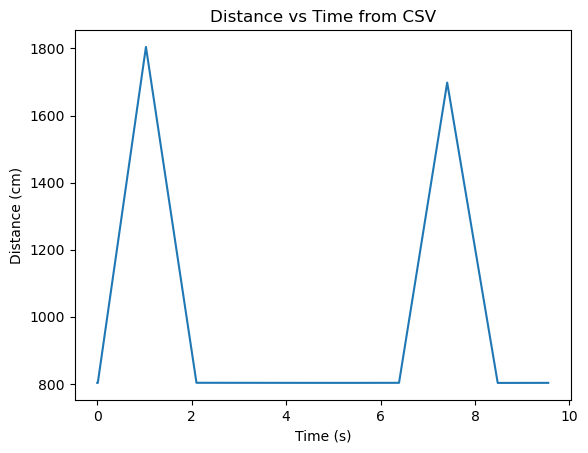

In [48]:
import csv
import matplotlib.pyplot as plt

time_data = []
distance_data = []

# 1) Open the CSV file
with open("distance_data.csv", mode="r") as f:
    reader = csv.reader(f)
    
    # 2) Skip the header row if you have one
    header = next(reader)  # e.g., ["Time (s)", "Distance (cm)"]

    # 3) Read each row and parse the time and distance
    for row in reader:
        # row[0] should be the time, row[1] the distance
        time_value = float(row[0])
        dist_value = float(row[1])
        
        time_data.append(time_value)
        distance_data.append(dist_value)

# 4) Plot the data
plt.plot(time_data, distance_data)
plt.xlabel("Time (s)")
plt.ylabel("Distance (cm)")
plt.title("Distance vs Time from CSV")
plt.show()


In [50]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fft
from scipy.stats import entropy

def preprocess_signal(signal_data, fs):
    """Apply bandpass filter to remove noise."""
    lowcut, highcut = 1000, fs / 2 - 1000  
    sos = signal.butter(4, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return signal.sosfilt(sos, signal_data)

def extract_features(signal_data, fs):
    """Extract features from the ultrasonic signal."""
    filtered_signal = preprocess_signal(signal_data, fs)
    
   
    amplitude = np.max(np.abs(filtered_signal))
    
   
    threshold = 0.1 * amplitude
    indices = np.where(np.abs(filtered_signal) > threshold)[0]
    duration = (indices[-1] - indices[0]) / fs if len(indices) > 0 else 0
   
    rise_start, rise_end = int(0.1 * len(filtered_signal)), int(0.9 * len(filtered_signal))
    rise_time = (rise_end - rise_start) / fs
    
   
    energy = np.sum(filtered_signal ** 2)
    
    rms_voltage = np.sqrt(np.mean(filtered_signal ** 2))
    
    freq_spectrum = np.abs(fft.fft(filtered_signal))
    freqs = fft.fftfreq(len(filtered_signal), d=1/fs)
    peak_frequency = freqs[np.argmax(freq_spectrum[:len(freq_spectrum)//2])]
    
    hist, bin_edges = np.histogram(filtered_signal, bins=50, density=True)
    signal_entropy = entropy(hist + 1e-9)  # Small constant to avoid log(0)
 
    A_in, A_out = amplitude, np.max(np.abs(filtered_signal[len(filtered_signal)//2:]))
    signal_attenuation = 20 * np.log10(A_in / (A_out + 1e-9))
    
    material_factor = 1.0

    
    crack_direction_factor = np.random.uniform(0.5, 1.5) 
    return {
        "Amplitude": amplitude,
        "Duration": duration,
        "Rise Time": rise_time,
        "Energy": energy,
        "RMS Voltage": rms_voltage,
        "Peak Frequency": peak_frequency,
        "Signal Entropy": signal_entropy,
        "Signal Attenuation": signal_attenuation,
        "Material Factor": material_factor,
        "Crack Direction Factor": crack_direction_factor,
    }

## Testing 

fs = 100000  
signal_data = np.sin(2 * np.pi * 5000 * np.linspace(0, 0.01, fs)) + 0.2 * np.random.randn(fs)  
features = extract_features(signal_data, fs)
print(features)

{'Amplitude': 0.9289752972168636, 'Duration': 0.99999, 'Rise Time': 0.8, 'Energy': 3804.9314848583376, 'RMS Voltage': 0.19506233580213114, 'Peak Frequency': 42849.0, 'Signal Entropy': 3.1370018529725963, 'Signal Attenuation': -9.34996772132083e-09, 'Material Factor': 1.0, 'Crack Direction Factor': 0.7558476222745976}


In [ ]:
import serial
import time
import csv
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fft
from scipy.stats import entropy

# Initialize serial connection (replace with your Arduino's port)
ser = serial.Serial('COM10', 9600, timeout=1)

# Allow time for Arduino reset
time.sleep(2)

time_list = []
values = []

# Open a CSV file for writing
with open("distance_data.csv", mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Time (s)", "Distance (cm)"])  # CSV Header

    print("Logging distance for 10 seconds...")
    start_time = time.time()
    log_duration = 10  # seconds

    while True:
        current_time = time.time() - start_time
        if current_time > log_duration:
            break
        
        if ser.in_waiting > 0:
            line = ser.readline().decode('utf-8').strip()
            try:
                dist_value = float(line)  # Convert to float
                time_list.append(current_time)
                time_list.append(current_time + 0.01)
                values.append(2000 - dist_value)
                values.append(0)
                
                # Write data to CSV
                writer.writerow([round(current_time, 2), 2000 - dist_value])
                print(f"Time: {round(current_time, 2)}s | Distance: {dist_value} cm")
            
            except ValueError:
                print("Invalid data received, skipping...")

print("Done logging. CSV file saved as distance_data.csv")
ser.close()


# Feature Extraction Functions
def preprocess_signal(signal_data, fs):
    """Apply bandpass filter to remove noise."""
    lowcut, highcut = 10, fs / 2 - 1  # Ensure highcut is positive
    sos = signal.butter(4, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return signal.sosfilt(sos, signal_data)


def extract_features(signal_data, fs):
    """Extract features from the ultrasonic signal."""
    filtered_signal = preprocess_signal(signal_data, fs)
    
    amplitude = np.max(np.abs(filtered_signal))
    
    threshold = 0.1 * amplitude
    indices = np.where(np.abs(filtered_signal) > threshold)[0]
    duration = (indices[-1] - indices[0]) / fs if len(indices) > 0 else 0

    rise_start, rise_end = int(0.1 * len(filtered_signal)), int(0.9 * len(filtered_signal))
    rise_time = (rise_end - rise_start) / fs
    
    energy = np.sum(filtered_signal ** 2)
    
    rms_voltage = np.sqrt(np.mean(filtered_signal ** 2))
    
    freq_spectrum = np.abs(fft.fft(filtered_signal))
    freqs = fft.fftfreq(len(filtered_signal), d=1/fs)
    peak_frequency = freqs[np.argmax(freq_spectrum[:len(freq_spectrum)//2])]
    
    hist, bin_edges = np.histogram(filtered_signal, bins=50, density=True)
    signal_entropy = entropy(hist + 1e-9)  
    
    A_in, A_out = amplitude, np.max(np.abs(filtered_signal[len(filtered_signal)//2:]))
    signal_attenuation = 20 * np.log10(A_in / (A_out + 1e-9))
    
    material_factor = 1.0
    crack_direction_factor = np.random.uniform(0.5, 1.5)  
    
    return {
        "Amplitude": amplitude,
        "Duration": duration,
        "Rise Time": rise_time,
        "Energy": energy,
        "RMS Voltage": rms_voltage,
        "Peak Frequency": peak_frequency,
        "Signal Entropy": signal_entropy,
        "Signal Attenuation": signal_attenuation,
        "Material Factor": material_factor,
        "Crack Direction Factor": crack_direction_factor,
    }

fs = 100 

if len(values) > 0:
    normal_features = extract_features(values, fs)
    print("\nNormal Pipe Signal Features:", normal_features)
else:
    print("No valid signal data collected for feature extraction.")
